# Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import jax
import jax.numpy as jnp
import sklearn.metrics as metrics
from scipy.stats import bernoulli
from textwrap import wrap

# set random seed
np.random.seed(9)

# Configuration parameters

In [2]:
num_att_buckets = 3  # number of attenuation buckets
att_buckets = ['far', 'medium', 'near']  # attenuation bucket names

# training configuration
num_train_iters = 2000  # number of training iterations
lr = 0.0005   # learning rate
train_frac = 0.7 # fraction of data to train on
max_batch_size = 10000  # batch size
num_random_restarts = 5  # number of random restarts

if_debug = False   # enable debugging info

# Simulate exposure data

In [3]:

def simulate_exposures(N, duration_lims, att_bucket_mixture_probs):
  """
  N: Population size  
  duration_lims: Lower and upper time limits for each attenuation bucket. Duration 
                 for each attenuation bucket is sampled from a uniform 
                 distribution within these limits.
  att_bucket_mixture_probs: mixture probabilities for sampling attenuation buckets
  """
  
  num_buckets = len(duration_lims)
  num_feats = num_buckets  

  num_exposures = 5  # number of exposures per user
  data = np.zeros((N,num_exposures,num_feats))
  exposure_types = np.random.choice([t[0] for t in att_bucket_mixture_probs.items()], size=(N, num_exposures), p=[t[1] for t in att_bucket_mixture_probs.items()])    
  for ind, dur_type in enumerate(att_buckets):
    duration_sim = np.random.rand(N, num_exposures) * (duration_lims[dur_type][1] - duration_lims[dur_type][0]) + duration_lims[dur_type][0]
    data[:,:,ind] = duration_sim * (exposure_types == dur_type)

  data = np.sum(data, axis=1)  # sum over all exposures 
  return data


# Probability of infection

In [4]:
@jax.jit
def hazard(exposures, weights_residual):
  """Implement multi-linear hazard function.
  exposures: features of exposures
  weights_residual: residual parameters (to be converted to parameters used for score computation)
  """

  # durations for each attenuation bucket
  att_durations = exposures[0:num_att_buckets]

  # transform model parameters (residual weights) to parameters used to compute the score
  weights_score = get_scoring_parameters(weights_residual)  

  weights_duration = weights_score[0:num_att_buckets]
  duration_score = 0
  for i in range(num_att_buckets):
    duration_score += weights_duration[i] * att_durations[i]
  return duration_score

@jax.jit
def prob_infected(exposures, weights_residual):
  """Probability of infection. 
  exposures: features of exposures
  weights_residual: residual parameters 
  """
  h = hazard(exposures, weights_residual)
  p_infected = 1 - jnp.exp(-1*h)
  p_infected = jnp.clip(p_infected, 1e-6, 1-1e-6) # clipping to prevent NaNs due to log
  return p_infected

prob_infected_vmap = jax.vmap(prob_infected, (0, None), 0)


# Convert between model parameters (residual) and score parameters (absolute)

In [5]:
@jax.jit
def get_scoring_parameters(weights):
  """Transform residual parameters to scoring parameters that respect monotonocity constraints. 
  weights: residual parameters (nonnegative)
  """  
  weights_duration = weights[:num_att_buckets]    

  weights_duration_scoring = [None] * num_att_buckets
  # monotonic weights for buckets, eg, w[near] > w[far]
  w_prev = 0
  for i in range(num_att_buckets):
    weights_duration_scoring[i] = w_prev + weights_duration[i]
    w_prev = weights_duration_scoring[i]    
  weights_scoring = weights_duration_scoring
  return weights_scoring

def print_params(weights):
  """print parameters"""
  weights_duration = weights[0:num_att_buckets]    
  print ('\tduration: {}'.format([round(w,3) for w in weights_duration]))


def get_residual_parameters(weights):
  """Transform scoring parameters to learnable residual parameters. Inverse transform of 'get_scoring_parameters()'. 
  weights: residual parameters
  """
  weights_duration = weights[:num_att_buckets]
  
  weights_duration_residual = [None] * num_att_buckets
  w_prev = 0
  for i in range(num_att_buckets):
    weights_duration_residual[i] = weights_duration[i] - w_prev
    w_prev = weights_duration[i]

  weights_residual = weights_duration_residual
  return np.asarray(weights_residual)

def get_init_weights():
  """Initial (residual) parameters for learning. """
  weights_duration = np.random.rand(num_att_buckets)*0.001  # random init
  weights = weights_duration
  return weights

# Loss and Training  

In [6]:
@jax.jit
def loss_fn(params, batch_x, batch_y):  
  """Cross entropy loss. 
  params: residual parameters
  batch_x: batch of features
  batch_y: batch of labels
  """
  probs = prob_infected_vmap(batch_x, params)
  loss = -1 * jnp.mean(batch_y*jnp.log(probs) + (1-batch_y)*jnp.log(1-probs))
  return loss

def project(params):
  """Project residual parameters to nonnegative orthant."""
  params = np.clip(params, 0, np.infty)
  return params

def train(data, labels, weights_init, batch_size=100, num_iters=1000, lr=0.01):
  """Training routine. 
  data: exposure features (N x d)
  labels: binary labels (N x 1)
  weights_init: initial residual parameters 
  batch_size: batch size for SGD
  num_iters: number of training iterations
  lr: initial learning rate (can be annealed if needed)
  """
  batch_start = 0  # batch start index
  num_samples = len(data)  # number of total training examples
  # gradient of loss
  loss_val_and_grad_fn = jax.jit(jax.value_and_grad(loss_fn, argnums=0))
    
  loss_init = loss_fn(weights_init, data, labels)
  print ('init params (model): {}'.format(weights_init))
  print ('init params (scoring): {}'.format(np.asarray(get_scoring_parameters(weights_init))))
  print ('loss at init: {}'.format(loss_init))
  params = weights_init
  for it in range(num_iters):
    batch_end = batch_start + batch_size
    if batch_end > num_samples:
      batch_x = np.asarray(list(data[batch_start:]) + list(data[:batch_end-num_samples]))
      batch_y = np.array(list(labels[batch_start:]) + list(labels[:batch_end-num_samples]))
      batch_start = batch_end-num_samples      
    else:
      batch_x = data[batch_start:batch_end]
      batch_y = labels[batch_start:batch_end]
      batch_start += batch_size
    batch_loss, grad = loss_val_and_grad_fn(params, batch_x, batch_y)    
    params -= lr*grad
    params = project(params)
    if it % 500 == 0:
      print ('Iter {}: loss {}'.format(it, batch_loss))
  return params




# Plotting routines

In [7]:
def plot_xy(xs, ys, lws, labels, linestyles, xlabel, ylabel, title, yerr=None, colors=None, xlim=None, ylim=None, legend_loc="lower right"):
  if yerr is None:
    yerr = [None] * len(xs)
  for i in range(len(xs)):
    if colors is not None:
      plt.errorbar(xs[i], ys[i], yerr=yerr[i], color=colors[i],
          lw=lws[i], label=labels[i], linestyle=linestyles[i])    
    else:
      plt.errorbar(xs[i], ys[i], yerr=yerr[i], lw=lws[i], label=labels[i], linestyle=linestyles[i])    
  if xlim is not None:
    plt.xlim(xlim)
  if ylim is not None:
    plt.ylim(ylim)
  plt.xlabel(xlabel, fontsize=14)
  plt.ylabel(ylabel, fontsize=14)
  plt.title('\n'.join(wrap(title)), fontsize=16)
  plt.legend(loc=legend_loc)
  plt.show()

def plot_metrics(scores_pred, scores, labels, sim_config):
  # roc curve
  plt_labels = []
  fpr, tpr, threshold = metrics.roc_curve(labels, scores_pred)
  roc_auc = metrics.auc(fpr, tpr)
  plt_labels.append('Est. param: ROC curve (area = %0.3f)' % roc_auc)
  fpr_gold, tpr_gold, threshold_gold = metrics.roc_curve(labels, scores)
  roc_auc_gold = metrics.auc(fpr_gold, tpr_gold)  
  plt_labels.append('True param: ROC curve (area = %0.3f)' % roc_auc_gold)
  plt_labels.append('')
  title = 'ROC on test set. N_trn={} (+ve {}, -ve {}), Att. bucket mixture={}'.format(sim_config["n_train"], sim_config["n_pos_train"], sim_config["n_neg_train"], sim_config["att_bucket_mix"])
  plot_xy(xs=[fpr, fpr_gold, [0,1]], ys=[tpr, tpr_gold, [0,1]], lws=[2,2,2], 
          labels=plt_labels, linestyles=['-','--','--'], xlabel='False Positive Rate', 
          ylabel='True Positive Rate', title=title, colors=['darkorange', 'darkorange', 'navy'], 
          xlim=[0., 1.], ylim=[0.,1.05])

  # precision-recall curve
  plt_labels = []
  prec, recall, threshold = metrics.precision_recall_curve(labels, scores_pred)
  avg_prec = metrics.average_precision_score(labels, scores_pred)
  plt_labels.append('Est. param: PR curve (avg precision = %0.3f)' % avg_prec)
  prec_gold, recall_gold, threshold_gold = metrics.precision_recall_curve(labels, scores)
  avg_prec_gold = metrics.average_precision_score(labels, scores)
  plt_labels.append('True param: PR curve (avg precision = %0.3f)' % avg_prec_gold)  
  title = 'PR curve on test set. N_trn={} (+ve {}, -ve {}), Att. bucket mixture={}'.format(sim_config["n_train"], sim_config["n_pos_train"], sim_config["n_neg_train"], sim_config["att_bucket_mix"])
  plot_xy(xs=[recall, recall_gold], ys=[prec, prec_gold], lws=[2,2], labels=plt_labels, 
          linestyles=['-','--'], xlabel='Precision', ylabel='Recall', title=title, 
          colors=['green', 'green', ], xlim=[0., 1.], ylim=[0.,1.05], legend_loc="upper right")
  return roc_auc, roc_auc_gold, avg_prec, avg_prec_gold

def plot_histogram(data, bins=20, title='scores'):
  hist, bins = np.histogram(data, bins=bins)
  plt.figure()
  plt.bar(bins[:-1], hist, width = 0.01)
  plt.xlim(min(bins), max(bins))
  plt.ylabel('scores',fontsize=15)
  plt.title(title,fontsize=15)
  plt.show()



# Learning demo

simulation configs: {1: {'n_train': 50, 'params_true': [0.001, 0.01, 0.2], 'att_bucket_mix': {'near': 0.001, 'medium': 0.005, 'far': 0.994}}, 2: {'n_train': 100, 'params_true': [0.001, 0.01, 0.2], 'att_bucket_mix': {'near': 0.001, 'medium': 0.005, 'far': 0.994}}, 3: {'n_train': 200, 'params_true': [0.001, 0.01, 0.2], 'att_bucket_mix': {'near': 0.001, 'medium': 0.005, 'far': 0.994}}, 4: {'n_train': 400, 'params_true': [0.001, 0.01, 0.2], 'att_bucket_mix': {'near': 0.001, 'medium': 0.005, 'far': 0.994}}, 5: {'n_train': 800, 'params_true': [0.001, 0.01, 0.2], 'att_bucket_mix': {'near': 0.001, 'medium': 0.005, 'far': 0.994}}, 6: {'n_train': 1600, 'params_true': [0.001, 0.01, 0.2], 'att_bucket_mix': {'near': 0.001, 'medium': 0.005, 'far': 0.994}}, 7: {'n_train': 3200, 'params_true': [0.001, 0.01, 0.2], 'att_bucket_mix': {'near': 0.001, 'medium': 0.005, 'far': 0.994}}, 8: {'n_train': 6400, 'params_true': [0.001, 0.01, 0.2], 'att_bucket_mix': {'near': 0.001, 'medium': 0.005, 'far': 0.994}}, 9

/Users/abhishk/Library/Python/3.6/lib/python/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


init params (model): [1.91663911e-05 6.50024855e-04 1.10983802e-05]
init params (scoring): [1.9166391e-05 6.6919124e-04 6.8028964e-04]
loss at init: 0.00022670513135381043
Iter 0: loss 0.00022670513135381043
Iter 500: loss 1.0132794159289915e-06
Iter 1000: loss 1.0132794159289915e-06
Iter 1500: loss 1.0132794159289915e-06
init params (model): [0.00011426 0.00066327 0.00062863]
init params (scoring): [0.00011426 0.00077753 0.00140616]
loss at init: 0.0007207330781966448
Iter 0: loss 0.0007207330781966448
Iter 500: loss 1.0132794159289915e-06
Iter 1000: loss 1.0132794159289915e-06
Iter 1500: loss 1.0132794159289915e-06
init params (model): [0.00021026 0.00064574 0.0007421 ]
init params (scoring): [0.00021026 0.000856   0.0015981 ]
loss at init: 0.0012134140124544501
Iter 0: loss 0.0012134140124544501
Iter 500: loss 1.0132794159289915e-06
Iter 1000: loss 1.0132794159289915e-06
Iter 1500: loss 1.0132794159289915e-06
init params (model): [1.63593966e-05 9.14276134e-04 5.85379394e-04]
init p

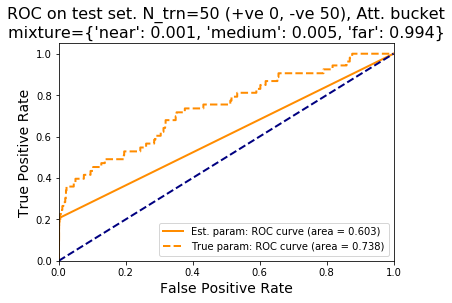

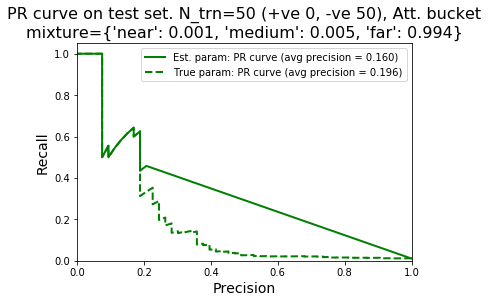



{'n_train': 100, 'params_true': [0.001, 0.01, 0.2], 'att_bucket_mix': {'near': 0.001, 'medium': 0.005, 'far': 0.994}} 

init params (model): [0.00091513 0.00023923 0.00059645]
init params (scoring): [0.00091513 0.00115436 0.00175081]
loss at init: 0.00453196931630373
Iter 0: loss 0.00453196931630373
Iter 500: loss 1.0132794159289915e-06
Iter 1000: loss 1.0132794159289915e-06
Iter 1500: loss 1.0132794159289915e-06
init params (model): [9.07454677e-05 2.50681345e-04 7.98960186e-04]
init params (scoring): [9.074547e-05 3.414268e-04 1.140387e-03]
loss at init: 0.0005096887471154332
Iter 0: loss 0.0005096887471154332
Iter 500: loss 1.0132794159289915e-06
Iter 1000: loss 1.0132794159289915e-06
Iter 1500: loss 1.0132794159289915e-06
init params (model): [4.29583451e-04 5.83340472e-05 4.30688527e-04]
init params (scoring): [0.00042958 0.00048792 0.00091861]
loss at init: 0.0021130642853677273
Iter 0: loss 0.0021130642853677273
Iter 500: loss 1.0132794159289915e-06
Iter 1000: loss 1.013279415

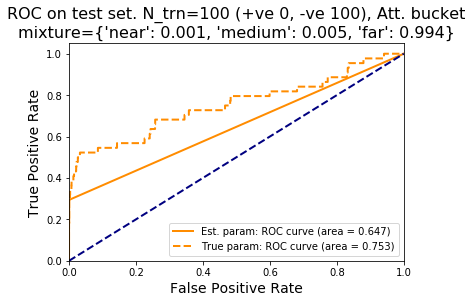

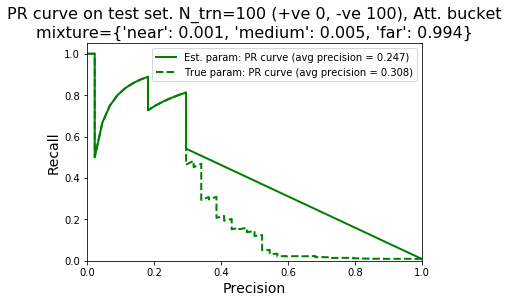



{'n_train': 200, 'params_true': [0.001, 0.01, 0.2], 'att_bucket_mix': {'near': 0.001, 'medium': 0.005, 'far': 0.994}} 

init params (model): [0.00026838 0.00034535 0.00098806]
init params (scoring): [0.00026838 0.00061373 0.00160179]
loss at init: 0.0014543985016644
Iter 0: loss 0.0014543985016644
Iter 500: loss 1.0132794159289915e-06
Iter 1000: loss 1.0132794159289915e-06
Iter 1500: loss 1.0132794159289915e-06
init params (model): [0.00045641 0.00073175 0.00098018]
init params (scoring): [0.00045641 0.00118816 0.00216834]
loss at init: 0.0024843078572303057
Iter 0: loss 0.0024843078572303057
Iter 500: loss 1.0132794159289915e-06
Iter 1000: loss 1.0132794159289915e-06
Iter 1500: loss 1.0132794159289915e-06
init params (model): [0.00070213 0.00073279 0.00097895]
init params (scoring): [0.00070213 0.00143492 0.00241387]
loss at init: 0.0037355595268309116
Iter 0: loss 0.0037355595268309116
Iter 500: loss 1.0132794159289915e-06
Iter 1000: loss 1.0132794159289915e-06
Iter 1500: loss 1.01

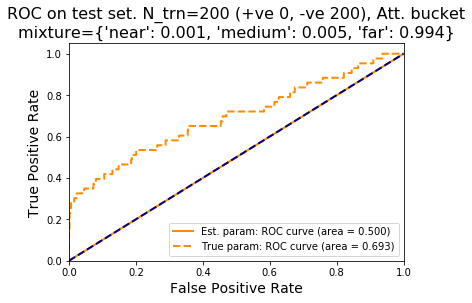

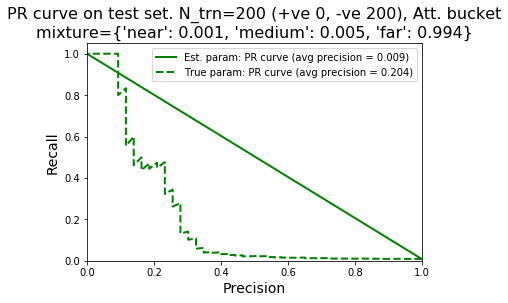



{'n_train': 400, 'params_true': [0.001, 0.01, 0.2], 'att_bucket_mix': {'near': 0.001, 'medium': 0.005, 'far': 0.994}} 

init params (model): [5.51956054e-04 6.14833151e-04 8.96998115e-05]
init params (scoring): [0.00055196 0.00116679 0.00125649]
loss at init: 0.04155605658888817
Iter 0: loss 0.04155605658888817
Iter 500: loss 0.2736065089702606
Iter 1000: loss 0.0336124524474144
Iter 1500: loss 0.09175121039152145
init params (model): [7.79966082e-04 5.06845506e-04 6.10554663e-05]
init params (scoring): [0.00077997 0.00128681 0.00134787]
loss at init: 0.04096607118844986
Iter 0: loss 0.04096607118844986
Iter 500: loss 0.0317813940346241
Iter 1000: loss 0.13155101239681244
Iter 1500: loss 0.08105912804603577
init params (model): [9.03062492e-05 8.62575360e-04 1.11591600e-04]
init params (scoring): [9.0306246e-05 9.5288164e-04 1.0644733e-03]
loss at init: 0.04615658521652222
Iter 0: loss 0.04615658521652222
Iter 500: loss 0.39798393845558167
Iter 1000: loss 0.30615493655204773
Iter 150

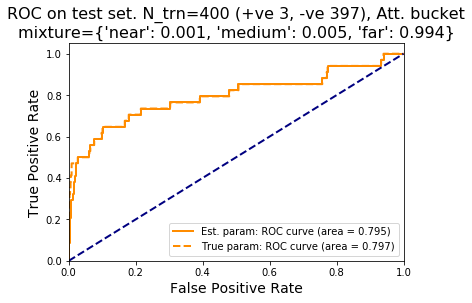

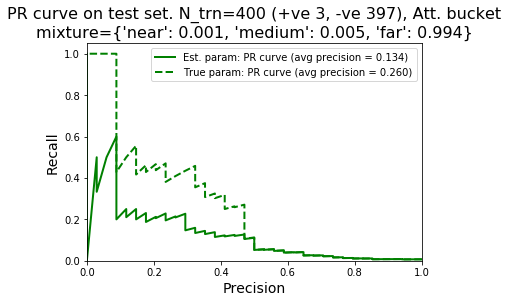



{'n_train': 800, 'params_true': [0.001, 0.01, 0.2], 'att_bucket_mix': {'near': 0.001, 'medium': 0.005, 'far': 0.994}} 

init params (model): [0.00027972 0.00072215 0.00057919]
init params (scoring): [0.00027972 0.00100186 0.00158105]
loss at init: 0.01414816826581955
Iter 0: loss 0.01414816826581955
Iter 500: loss 0.008310064673423767
Iter 1000: loss 0.008030186407268047
Iter 1500: loss 0.00786558073014021
init params (model): [0.00027658 0.00015127 0.00025634]
init params (scoring): [0.00027658 0.00042785 0.00068418]
loss at init: 0.015584590844810009
Iter 0: loss 0.015584590844810009
Iter 500: loss 0.00826571136713028
Iter 1000: loss 0.008016309700906277
Iter 1500: loss 0.007855677977204323
init params (model): [0.00085614 0.00030709 0.00041449]
init params (scoring): [0.00085614 0.00116323 0.00157772]
loss at init: 0.01603568345308304
Iter 0: loss 0.01603568345308304
Iter 500: loss 0.00826439168304205
Iter 1000: loss 0.008015491999685764
Iter 1500: loss 0.00785511638969183
init pa

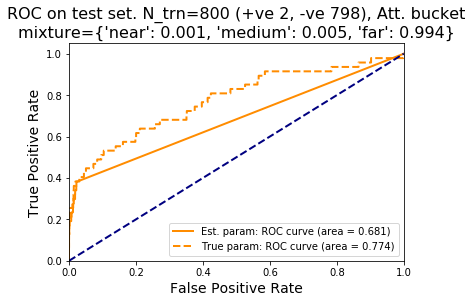

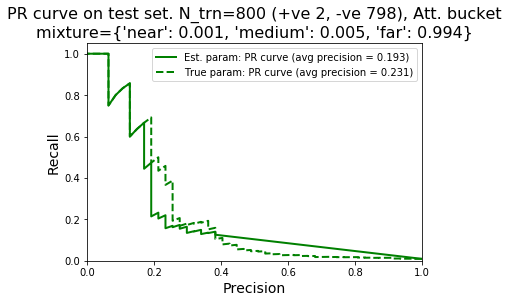



{'n_train': 1600, 'params_true': [0.001, 0.01, 0.2], 'att_bucket_mix': {'near': 0.001, 'medium': 0.005, 'far': 0.994}} 

init params (model): [1.00414202e-05 9.95229216e-04 5.70407300e-04]
init params (scoring): [1.0041420e-05 1.0052706e-03 1.5756779e-03]
loss at init: 0.04687751829624176
Iter 0: loss 0.04687751829624176
Iter 500: loss 0.03153104707598686
Iter 1000: loss 0.03186644986271858
Iter 1500: loss 0.03164473921060562
init params (model): [1.17611572e-04 1.38131144e-04 9.91277742e-05]
init params (scoring): [0.00011761 0.00025574 0.00035487]
loss at init: 0.03730100393295288
Iter 0: loss 0.03730100393295288
Iter 500: loss 0.03362047299742699
Iter 1000: loss 0.03167743235826492
Iter 1500: loss 0.034632161259651184
init params (model): [0.00064794 0.00066583 0.00094683]
init params (scoring): [0.00064794 0.00131377 0.0022606 ]
loss at init: 0.0316191203892231
Iter 0: loss 0.0316191203892231
Iter 500: loss 0.0317753441631794
Iter 1000: loss 0.03174393251538277
Iter 1500: loss 0.

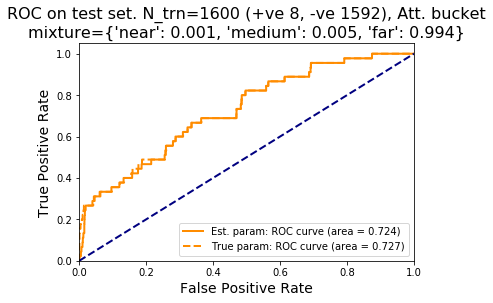

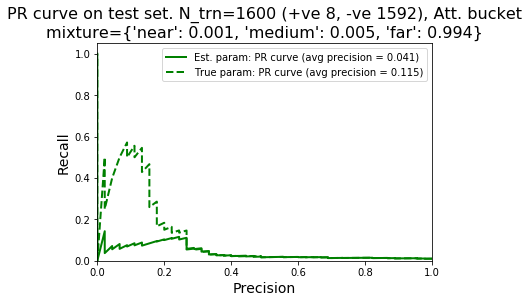



{'n_train': 3200, 'params_true': [0.001, 0.01, 0.2], 'att_bucket_mix': {'near': 0.001, 'medium': 0.005, 'far': 0.994}} 

init params (model): [0.00033673 0.00096189 0.00075241]
init params (scoring): [0.00033673 0.00129863 0.00205104]
loss at init: 0.04749779775738716
Iter 0: loss 0.04749779775738716
Iter 500: loss 0.040673673152923584
Iter 1000: loss 0.04054706171154976
Iter 1500: loss 0.0402003675699234
init params (model): [9.48517629e-04 5.79456136e-04 8.89084501e-05]
init params (scoring): [0.00094852 0.00152797 0.00161688]
loss at init: 0.04489395022392273
Iter 0: loss 0.04489395022392273
Iter 500: loss 0.03941471874713898
Iter 1000: loss 0.0391056090593338
Iter 1500: loss 0.038862284272909164
init params (model): [0.00057494 0.00089426 0.00022803]
init params (scoring): [0.00057494 0.0014692  0.00169723]
loss at init: 0.04590844362974167
Iter 0: loss 0.04590844362974167
Iter 500: loss 0.039552249014377594
Iter 1000: loss 0.0391373448073864
Iter 1500: loss 0.03911668062210083
i

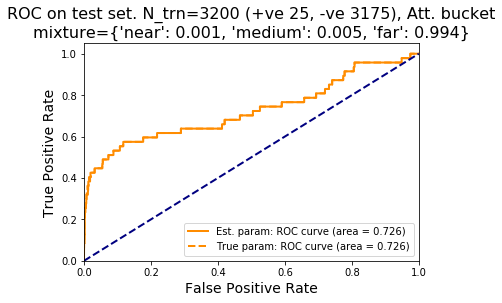

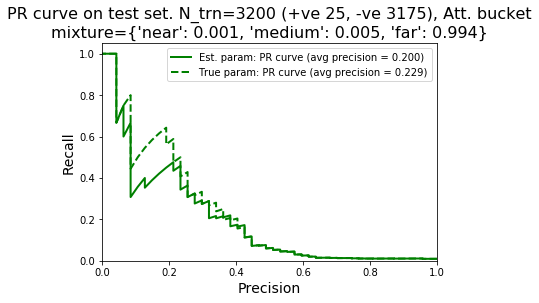



{'n_train': 6400, 'params_true': [0.001, 0.01, 0.2], 'att_bucket_mix': {'near': 0.001, 'medium': 0.005, 'far': 0.994}} 

init params (model): [0.00071292 0.00044664 0.00079975]
init params (scoring): [0.00071292 0.00115955 0.0019593 ]
loss at init: 0.057581499218940735
Iter 0: loss 0.057581499218940735
Iter 500: loss 0.04856858029961586
Iter 1000: loss 0.04811326041817665
Iter 1500: loss 0.04781556501984596
init params (model): [0.00036456 0.00091291 0.00041812]
init params (scoring): [0.00036456 0.00127748 0.0016956 ]
loss at init: 0.060966622084379196
Iter 0: loss 0.060966622084379196
Iter 500: loss 0.04858134686946869
Iter 1000: loss 0.048122476786375046
Iter 1500: loss 0.047822434455156326
init params (model): [5.76428695e-05 3.20401272e-04 5.48550059e-04]
init params (scoring): [5.7642868e-05 3.7804415e-04 9.2659419e-04]
loss at init: 0.0747985690832138
Iter 0: loss 0.0747985690832138
Iter 500: loss 0.04859025031328201
Iter 1000: loss 0.04812488332390785
Iter 1500: loss 0.047823

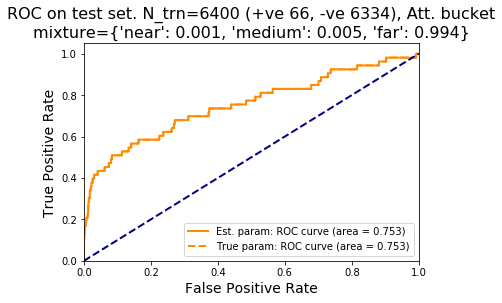

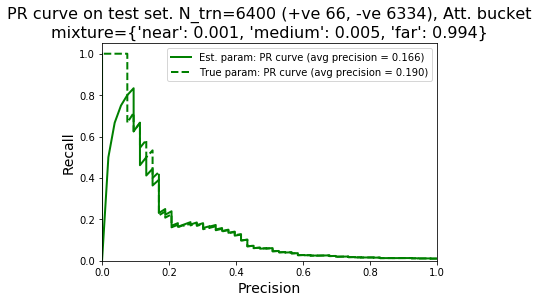



{'n_train': 50, 'params_true': [0.001, 0.01, 0.2], 'att_bucket_mix': {'near': 0.05, 'medium': 0.1, 'far': 0.85}} 

init params (model): [0.00074357 0.00073898 0.00024363]
init params (scoring): [0.00074357 0.00148255 0.00172618]
loss at init: 0.2197664976119995
Iter 0: loss 0.2197664976119995
Iter 500: loss 0.10879569500684738
Iter 1000: loss 0.10561713576316833
Iter 1500: loss 0.10467754304409027
init params (model): [6.13640756e-05 9.44577378e-04 3.80361884e-06]
init params (scoring): [6.1364073e-05 1.0059414e-03 1.0097451e-03]
loss at init: 0.26603880524635315
Iter 0: loss 0.26603880524635315
Iter 500: loss 0.10879811644554138
Iter 1000: loss 0.10561774671077728
Iter 1500: loss 0.10467775166034698
init params (model): [0.00016817 0.00088375 0.00076666]
init params (scoring): [0.00016817 0.00105192 0.00181858]
loss at init: 0.2397395521402359
Iter 0: loss 0.2397395521402359
Iter 500: loss 0.11068052053451538
Iter 1000: loss 0.10640353709459305
Iter 1500: loss 0.10503523796796799
in

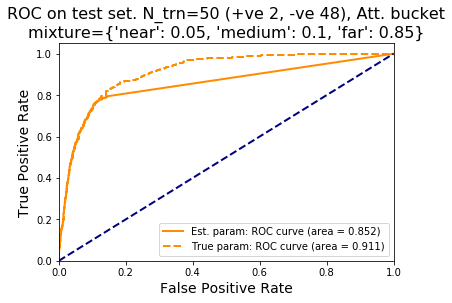

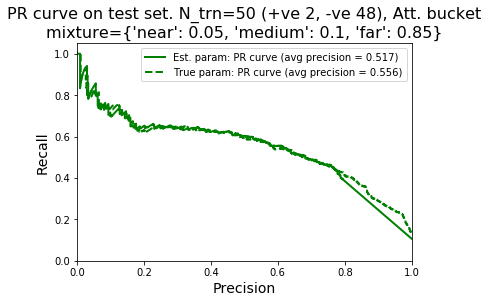



{'n_train': 100, 'params_true': [0.001, 0.01, 0.2], 'att_bucket_mix': {'near': 0.05, 'medium': 0.1, 'far': 0.85}} 

init params (model): [0.00081615 0.00010398 0.00048618]
init params (scoring): [0.00081615 0.00092013 0.00140631]
loss at init: 0.4304390251636505
Iter 0: loss 0.4304390251636505
Iter 500: loss 0.23761065304279327
Iter 1000: loss 0.23754741251468658
Iter 1500: loss 0.2375458925962448
init params (model): [0.00085891 0.00026065 0.0009664 ]
init params (scoring): [0.00085891 0.00111956 0.00208597]
loss at init: 0.4099719226360321
Iter 0: loss 0.4099719226360321
Iter 500: loss 0.23755809664726257
Iter 1000: loss 0.23750750720500946
Iter 1500: loss 0.23750713467597961
init params (model): [7.92724340e-05 1.99237102e-04 9.25748142e-05]
init params (scoring): [7.9272431e-05 2.7850951e-04 3.7108432e-04]
loss at init: 0.5645920634269714
Iter 0: loss 0.5645920634269714
Iter 500: loss 0.23753133416175842
Iter 1000: loss 0.23750728368759155
Iter 1500: loss 0.23750713467597961
init

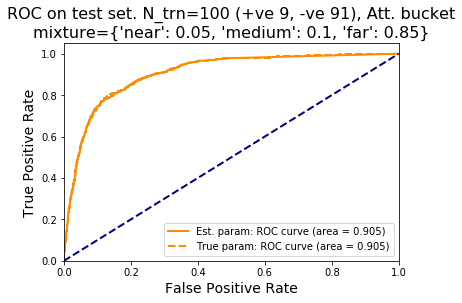

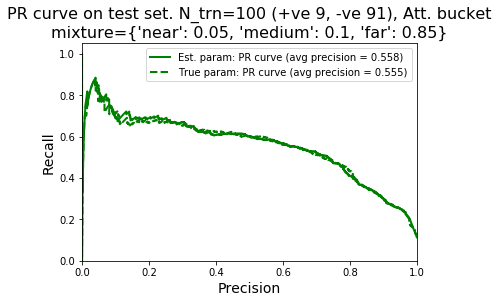



{'n_train': 200, 'params_true': [0.001, 0.01, 0.2], 'att_bucket_mix': {'near': 0.05, 'medium': 0.1, 'far': 0.85}} 

init params (model): [0.00095689 0.00055255 0.00079563]
init params (scoring): [0.00095689 0.00150944 0.00230506]
loss at init: 0.3930070102214813
Iter 0: loss 0.3930070102214813
Iter 500: loss 0.1736830323934555
Iter 1000: loss 0.17126652598381042
Iter 1500: loss 0.17080651223659515
init params (model): [0.00057779 0.00040282 0.00050088]
init params (scoring): [0.00057779 0.00098061 0.00148149]
loss at init: 0.43081462383270264
Iter 0: loss 0.43081462383270264
Iter 500: loss 0.17367124557495117
Iter 1000: loss 0.17126460373401642
Iter 1500: loss 0.17080608010292053
init params (model): [0.00026645 0.00057293 0.00011773]
init params (scoring): [0.00026645 0.00083938 0.00095711]
loss at init: 0.46746164560317993
Iter 0: loss 0.46746164560317993
Iter 500: loss 0.17358793318271637
Iter 1000: loss 0.171251118183136
Iter 1500: loss 0.17080295085906982
init params (model): [0

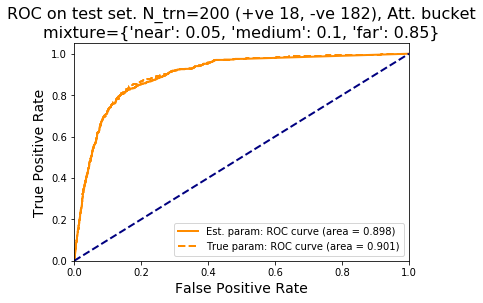

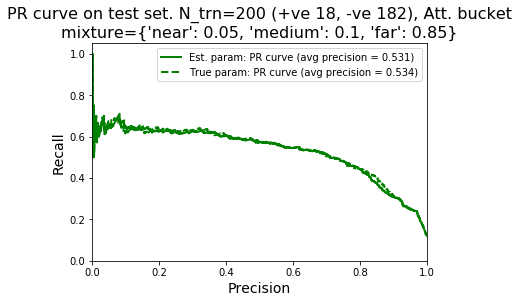



{'n_train': 400, 'params_true': [0.001, 0.01, 0.2], 'att_bucket_mix': {'near': 0.05, 'medium': 0.1, 'far': 0.85}} 

init params (model): [7.19374928e-05 4.29604448e-04 9.05230684e-04]
init params (scoring): [7.1937495e-05 5.0154194e-04 1.4067726e-03]
loss at init: 0.6564218997955322
Iter 0: loss 0.6564218997955322
Iter 500: loss 0.23055627942085266
Iter 1000: loss 0.22572919726371765
Iter 1500: loss 0.2247561365365982
init params (model): [0.00029844 0.00060462 0.0009843 ]
init params (scoring): [0.00029844 0.00090306 0.00188736]
loss at init: 0.598213791847229
Iter 0: loss 0.598213791847229
Iter 500: loss 0.23047980666160583
Iter 1000: loss 0.22571633756160736
Iter 1500: loss 0.22475291788578033
init params (model): [0.0007871  0.00019196 0.00014356]
init params (scoring): [0.0007871  0.00097905 0.00112262]
loss at init: 0.5978028178215027
Iter 0: loss 0.5978028178215027
Iter 500: loss 0.23044495284557343
Iter 1000: loss 0.22571046650409698
Iter 1500: loss 0.22475147247314453
init p

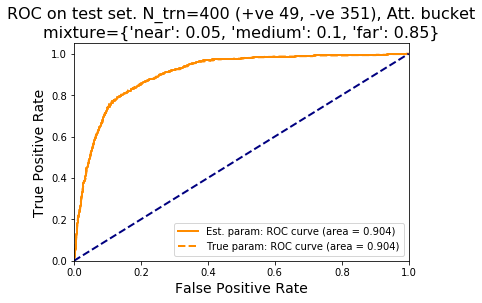

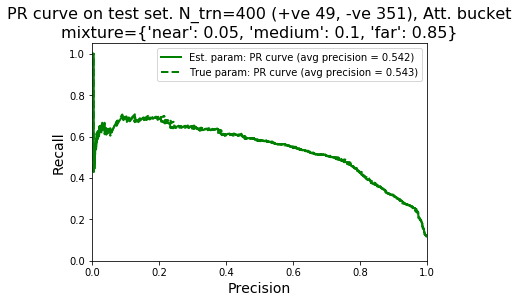



{'n_train': 800, 'params_true': [0.001, 0.01, 0.2], 'att_bucket_mix': {'near': 0.05, 'medium': 0.1, 'far': 0.85}} 

init params (model): [0.00035073 0.0002154  0.00078223]
init params (scoring): [0.00035073 0.00056613 0.00134836]
loss at init: 0.634812593460083
Iter 0: loss 0.634812593460083
Iter 500: loss 0.24463500082492828
Iter 1000: loss 0.23854276537895203
Iter 1500: loss 0.2368505597114563
init params (model): [0.00041571 0.0007194  0.00086438]
init params (scoring): [0.00041571 0.0011351  0.00199948]
loss at init: 0.5848994255065918
Iter 0: loss 0.5848994255065918
Iter 500: loss 0.2445937991142273
Iter 1000: loss 0.23853325843811035
Iter 1500: loss 0.23684735596179962
init params (model): [0.00099689 0.00043526 0.00018055]
init params (scoring): [0.00099689 0.00143215 0.0016127 ]
loss at init: 0.5620052814483643
Iter 0: loss 0.5620052814483643
Iter 500: loss 0.24456171691417694
Iter 1000: loss 0.23852580785751343
Iter 1500: loss 0.23684483766555786
init params (model): [0.0009

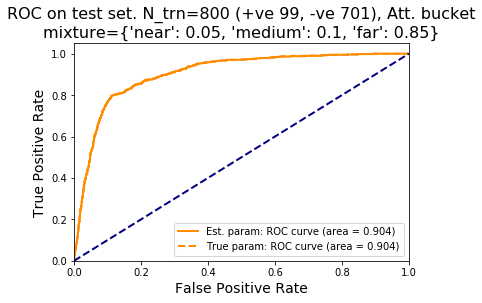



{'n_train': 1600, 'params_true': [0.001, 0.01, 0.2], 'att_bucket_mix': {'near': 0.05, 'medium': 0.1, 'far': 0.85}} 

init params (model): [0.00082642 0.00023413 0.00017508]
init params (scoring): [0.00082642 0.00106056 0.00123564]
loss at init: 0.566628098487854
Iter 0: loss 0.566628098487854
Iter 500: loss 0.24099306762218475
Iter 1000: loss 0.23604239523410797
Iter 1500: loss 0.23482787609100342
init params (model): [0.00092415 0.00085845 0.00058728]
init params (scoring): [0.00092415 0.0017826  0.00236988]
loss at init: 0.5163808465003967
Iter 0: loss 0.5163808465003967
Iter 500: loss 0.24102285504341125
Iter 1000: loss 0.23604850471019745
Iter 1500: loss 0.23482970893383026
init params (model): [0.00041036 0.00066345 0.00050638]
init params (scoring): [0.00041036 0.00107381 0.00158019]
loss at init: 0.5757555365562439
Iter 0: loss 0.5757555365562439
Iter 500: loss 0.24100783467292786
Iter 1000: loss 0.23604540526866913
Iter 1500: loss 0.23482878506183624
init params (model): [0.0

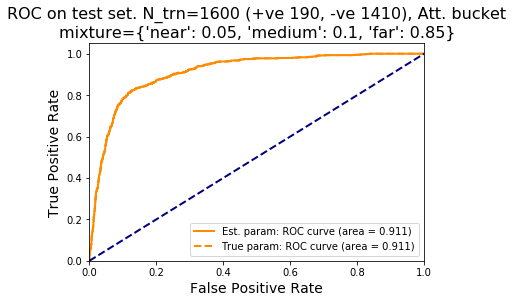

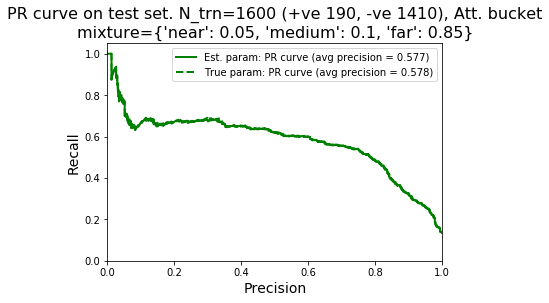



{'n_train': 3200, 'params_true': [0.001, 0.01, 0.2], 'att_bucket_mix': {'near': 0.05, 'medium': 0.1, 'far': 0.85}} 

init params (model): [7.97534583e-04 6.87952426e-04 5.17431597e-05]
init params (scoring): [0.00079753 0.00148549 0.00153723]
loss at init: 0.5299420356750488
Iter 0: loss 0.5299420356750488
Iter 500: loss 0.2290317416191101
Iter 1000: loss 0.22471879422664642
Iter 1500: loss 0.22374895215034485
init params (model): [0.00076859 0.00044448 0.0002115 ]
init params (scoring): [0.00076859 0.00121307 0.00142457]
loss at init: 0.5406233668327332
Iter 0: loss 0.5406233668327332
Iter 500: loss 0.22903136909008026
Iter 1000: loss 0.22471871972084045
Iter 1500: loss 0.22374895215034485
init params (model): [1.19682438e-05 4.09010597e-04 4.53383205e-04]
init params (scoring): [1.1968244e-05 4.2097885e-04 8.7436207e-04]
loss at init: 0.6634427309036255
Iter 0: loss 0.6634427309036255
Iter 500: loss 0.22931501269340515
Iter 1000: loss 0.22477172315120697
Iter 1500: loss 0.223763421

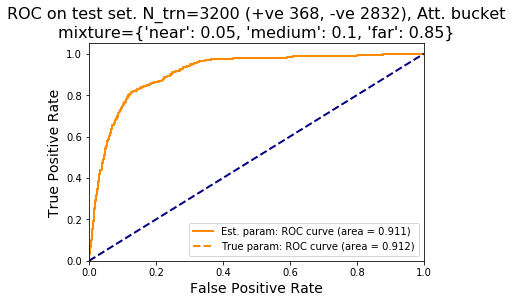

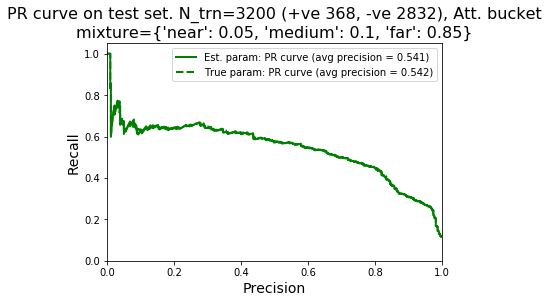



{'n_train': 6400, 'params_true': [0.001, 0.01, 0.2], 'att_bucket_mix': {'near': 0.05, 'medium': 0.1, 'far': 0.85}} 

init params (model): [0.00054044 0.00037731 0.0005428 ]
init params (scoring): [0.00054044 0.00091776 0.00146056]
loss at init: 0.5309162139892578
Iter 0: loss 0.5309162139892578
Iter 500: loss 0.21973080933094025
Iter 1000: loss 0.21539197862148285
Iter 1500: loss 0.21438993513584137
init params (model): [0.00065807 0.00089266 0.00081687]
init params (scoring): [0.00065807 0.00155072 0.00236759]
loss at init: 0.4872168302536011
Iter 0: loss 0.4872168302536011
Iter 500: loss 0.21974065899848938
Iter 1000: loss 0.21539388597011566
Iter 1500: loss 0.21439044177532196
init params (model): [0.00060183 0.00088082 0.00064215]
init params (scoring): [0.00060183 0.00148265 0.0021248 ]
loss at init: 0.4962349832057953
Iter 0: loss 0.4962349832057953
Iter 500: loss 0.21973773837089539
Iter 1000: loss 0.2153933048248291
Iter 1500: loss 0.21439029276371002
init params (model): [0.

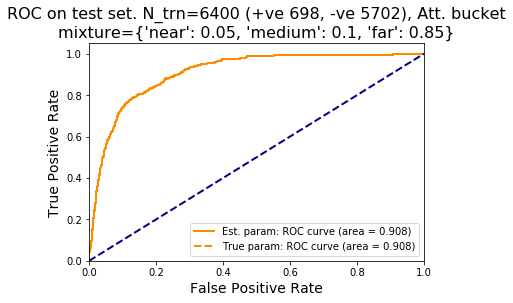

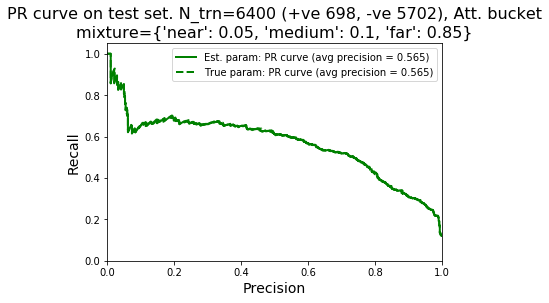

In [8]:
# Assumed durations limits for attenuation buckets (for simulating data)
duration_lims = dict()
duration_lims['near'] = [0, 5] # min, max in time units
duration_lims['medium'] = [0, 10] # min, max in time units
duration_lims['far'] = [0, 2] # min, max in time units

# number of training examples
sim_configs_n = [50, 100, 200, 400, 800, 1600, 3200, 6400]
# true weights for the attenuation windows
sim_configs_params_true = [[0.001, 0.01, 0.2]]
# mixture probability for sampling attenuation buckets
sim_config_att_bucket_mix = [dict(near=0.001, medium=0.005, far=0.994), dict(near=0.05, medium=0.1, far=0.85)]  
sim_key = 1
sim_configs = dict()
for p in sim_configs_params_true:
  for abm in sim_config_att_bucket_mix:
    for n in sim_configs_n:
      sim_configs.update({sim_key: dict(n_train=n, params_true=p, att_bucket_mix=abm)})
      sim_key += 1  

print ('simulation configs: {}'.format(sim_configs))

results = dict()
for s_key, s_config in sim_configs.items():
  print ('\n\n=============================================================')
  print (s_config, '\n')
  params_true = s_config["params_true"]
  params_true_residual = get_residual_parameters(params_true)
  att_bucket_mixture_probs = s_config["att_bucket_mix"]
  n_train = s_config["n_train"]   # number of training examples
  n_test = 5000   # number of test examples
  data = simulate_exposures(n_train+n_test, duration_lims, att_bucket_mixture_probs)    
  scores = prob_infected_vmap(data, params_true_residual)
  labels = bernoulli.rvs(p=scores)
  
  batch_size = min(max_batch_size, n_train)
  data_trn = data[:n_train]
  labels_trn = labels[:n_train]
  data_tst = data[n_train:]
  labels_tst = labels[n_train:]
  scores_tst = scores[n_train:]

  # debug 
  n_pos_train = np.sum(labels_trn)
  n_neg_train = n_train - np.sum(labels_trn)
  if if_debug:
    plot_histogram(scores, bins=50, title='true scores')
    plot_histogram(scores[:n_train], bins=50, title='true scores (train)')
    plot_histogram(scores[n_train:], bins=50, title='true scores (test)')
    print ('simulated data: positives {}, negatives {}'.format(np.sum(labels), len(labels)-np.sum(labels)))
    print ('\t train: positives {}, negatives {}'.format(n_pos_train, n_neg_train))
    print ('\t test: positives {}, negatives {}'.format(np.sum(labels_tst), len(labels_tst)-np.sum(labels_tst)))

  # test loss with true parameter
  loss_true_trn = loss_fn(params_true_residual, data_trn, labels_trn)
  loss_true_tst = loss_fn(params_true_residual, data_tst, labels_tst)
  
  # train
  losses_train = [None] * num_random_restarts
  params = [None] * num_random_restarts
  roc_auc_all = [None] * num_random_restarts
  avg_prec_all = [None] * num_random_restarts
  for i in range(num_random_restarts):
    weights_residual_init = get_init_weights()  
    params[i] = train(data_trn, labels_trn, weights_residual_init, batch_size=batch_size, num_iters=num_train_iters, lr=lr)
    losses_train[i] = loss_fn(params[i], data_trn, labels_trn)
    scores_pred_tst = prob_infected_vmap(data_tst, params[i])
    fpr, tpr, threshold = metrics.roc_curve(labels_tst, scores_pred_tst)
    roc_auc_all[i] = metrics.auc(fpr, tpr)
    avg_prec_all[i] = metrics.average_precision_score(labels_tst, scores_pred_tst)
  best_run = np.argmin(losses_train)
  best_loss_trn = losses_train[best_run]
  best_params = params[best_run]

  # predict
  scores_pred_tst = prob_infected_vmap(data_tst, best_params)
  print ('True parameters: train loss: {}, test loss: {}'.format(loss_true_trn, loss_true_tst))
  print_params(params_true)
  loss_tst = loss_fn(best_params, data_tst, labels_tst)
  print ('Estimated parameters: train loss: {}, test loss: {}'.format(best_loss_trn, loss_tst))
  print_params(np.asarray(get_scoring_parameters(best_params)))

  # metrics
  s_config["n_pos_train"] = n_pos_train
  s_config["n_neg_train"] = n_neg_train
  roc_auc, roc_auc_true, avg_prec, avg_prec_true = plot_metrics(scores_pred_tst, scores_tst, labels_tst, s_config)
  
  results[s_key] = dict(loss_true_tst=loss_true_tst, loss_tst=loss_tst, params=best_params, scores_pred_tst=scores_pred_tst, \
                        labels=labels, scores_tst=scores_tst, roc_auc=roc_auc, roc_auc_true=roc_auc_true, avg_prec=avg_prec, avg_prec_true=avg_prec_true, \
                        roc_auc_all=roc_auc_all, avg_prec_all=avg_prec_all, frac_pos_train=float(n_pos_train)/n_train)


# Plot summary of results 

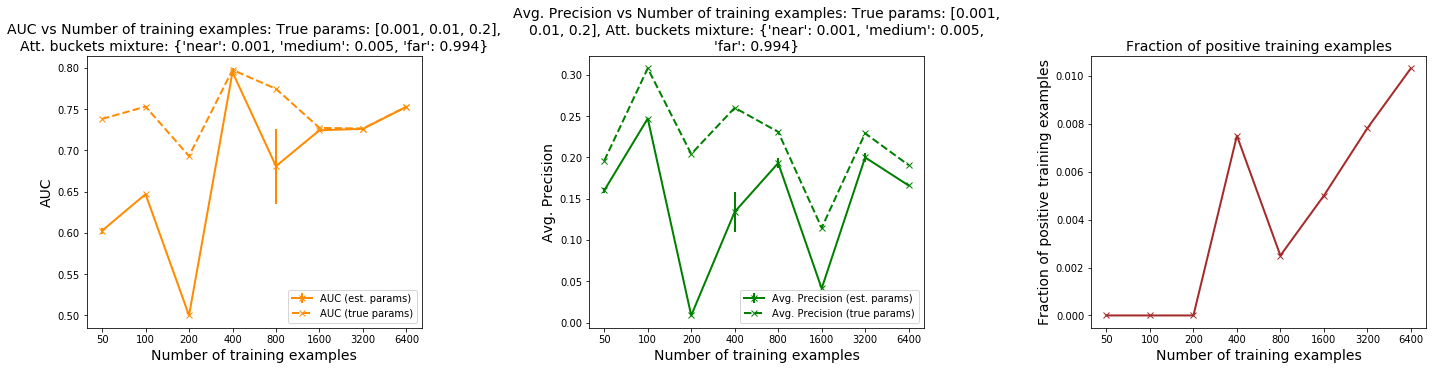

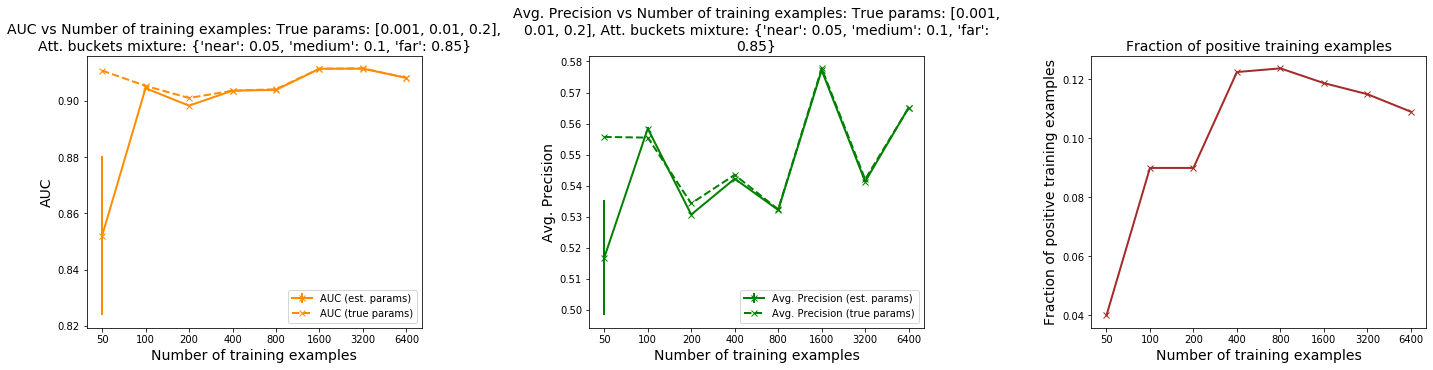

In [11]:
# collect results for each experiment configuarion for varying training set size
auc = dict()
auc_all = dict()
auc_true = dict()
avg_prec = dict()
avg_prec_all = dict()
avg_prec_true = dict()
frac_pos_trn = dict()

for s_key, s_config in sim_configs.items():
  result = results[s_key]  
  n = s_config["n_train"]
  auc_key = 'True params: {}, Att. buckets mixture: {}'.format(s_config["params_true"] , s_config["att_bucket_mix"])
  if auc_key not in auc:
    auc[auc_key] = [None] * len(sim_configs_n)
    auc_all[auc_key] = [None] * len(sim_configs_n)
    auc_true[auc_key] = [None] * len(sim_configs_n)
    avg_prec[auc_key] = [None] * len(sim_configs_n)
    avg_prec_all[auc_key] = [None] * len(sim_configs_n)  
    avg_prec_true[auc_key] = [None] * len(sim_configs_n)  
    frac_pos_trn[auc_key] = [None] * len(sim_configs_n)  
    
  auc[auc_key][sim_configs_n.index(n)] = result["roc_auc"]
  auc_all[auc_key][sim_configs_n.index(n)] = result["roc_auc_all"]
  auc_true[auc_key][sim_configs_n.index(n)] = result["roc_auc_true"]
  avg_prec[auc_key][sim_configs_n.index(n)]= result["avg_prec"]
  avg_prec_all[auc_key][sim_configs_n.index(n)]= result["avg_prec_all"]
  avg_prec_true[auc_key][sim_configs_n.index(n)]= result["avg_prec_true"]
  frac_pos_trn[auc_key][sim_configs_n.index(n)]= result["frac_pos_train"]


# plot AUC / Average precision vs training sample size
if_plot_errbars = True
for k in auc:
  yerr_auc = list(map(np.std, auc_all[k])) if if_plot_errbars else None
  yerr_prec =  list(map(np.std, avg_prec_all[k])) if if_plot_errbars else None
  
  fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(24,5))  
  plt.subplots_adjust(wspace=0.5)
  plt.setp(ax, xticks=np.arange(len(sim_configs_n)), xticklabels=sim_configs_n)
  
  # plot AUC vs training size     
  title = '\n'.join(wrap('AUC vs Number of training examples: {}'.format(k)))
  ax[0].errorbar(np.arange(len(sim_configs_n)), auc[k], yerr=yerr_auc, lw=2, color='darkorange', label='AUC (est. params)', linestyle='-', marker='x')
  ax[0].errorbar(np.arange(len(sim_configs_n)), auc_true[k], yerr=None, lw=2, color='darkorange', label='AUC (true params)', linestyle='--', marker='x')
  ax[0].set_title(title, fontsize=14)
  ax[0].set_xlabel('Number of training examples', fontsize=14)
  ax[0].set_ylabel('AUC', fontsize=14)
  ax[0].legend(loc='lower right')  
  # ax[0].set_xticks(sim_configs_n)
  

  # plot average precision vs training size
  title = '\n'.join(wrap('Avg. Precision vs Number of training examples: {}'.format(k)))
  ax[1].errorbar(np.arange(len(sim_configs_n)), avg_prec[k], yerr=yerr_prec, lw=2, color='green', label='Avg. Precision (est. params)', linestyle='-', marker='x')
  ax[1].errorbar(np.arange(len(sim_configs_n)), avg_prec_true[k], yerr=None, lw=2, color='green', label='Avg. Precision (true params)', linestyle='--', marker='x')
  ax[1].set_title(title, fontsize=14)
  ax[1].set_xlabel('Number of training examples', fontsize=14)
  ax[1].set_ylabel('Avg. Precision', fontsize=14)
  ax[1].legend(loc='lower right')    

  # plot fraction of positive training examples for these runs
  title = '\n'.join(wrap('Fraction of positive training examples'))
  ax[2].plot(np.arange(len(sim_configs_n)), frac_pos_trn[k], lw=2, color='brown', marker='x')
  ax[2].set_title(title, fontsize=14)
  ax[2].set_xlabel('Number of training examples', fontsize=14)
  ax[2].set_ylabel('Fraction of positive training examples', fontsize=14)
  
  plt.show()
